In [1]:
import seaborn as sns
import pandas as pd
import geopandas as gpd
import pysal
import numpy as np
import mapclassify
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore') # Change settings so that warnings are not displayed

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6) #this increases the inline figure size to 15 tall x 10 wide


import contextily as cx
from shapely.geometry import Polygon
import plotly.express as px
from pysal.explore import esda
from pysal.lib import weights
from splot.esda import plot_moran
from splot.esda import moran_scatterplot
from splot.esda import plot_local_autocorrelation
from splot.esda import lisa_cluster
from esda.moran import Moran_Local

# Loading a few new packages
from scipy import stats
from pysal.model import spreg
import statsmodels.formula.api as sm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

/Users/sreevathsadb/miniforge3/envs/geo_env/lib/python3.10/site-packages/pysal/explore/segregation/network/network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
/Users/sreevathsadb/miniforge3/envs/geo_env/lib/python3.10/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
hp = gpd.read_file('/Users/sreevathsadb/Masters/Sem 2/Data Analytics Project/Data/Project/houses_lb.geojson')
lb = gpd.read_file('/Users/sreevathsadb/Masters/Sem 2/Data Analytics Project/Data/london_boroughs.geojson')
hp_all = gpd.read_file('/Users/sreevathsadb/Masters/Sem 2/Data Analytics Project/Data/houses_lr.geojson')
profiles = pd.read_csv('/Users/sreevathsadb/Masters/Sem 2/Data Analytics Project/Data/lb_profiles.csv')

In [3]:
lb_map = lb.merge(profiles)

## Houses Contructed Vs Year 

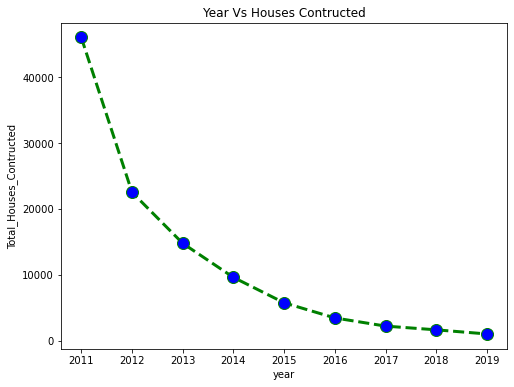

In [4]:
hp_all = gpd.read_file('/Users/sreevathsadb/Masters/Sem 2/Data Analytics Project/Data/houses_lr.geojson')
houses_unique = hp_all.sort_values('year').groupby('postcode').first().reset_index()
houses_unique_lb = gpd.sjoin(houses_unique,lb_map)
houses_count_year = houses_unique.groupby(['year'])['postcode'].count().reset_index(name ='Total_Houses_Contructed')
plt.plot(houses_count_year['year'], houses_count_year['Total_Houses_Contructed'], color='green', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=12)
plt.xlabel('year')
plt.ylabel('Total_Houses_Contructed')
plt.title('Year Vs Houses Contructed')
plt.show()

We can see construction of the houses exponentially descreasing over the years with rapid decrease between 2011 and 2013. This could be one of the factors for housing crisis which may have led to increase in house price.

<AxesSubplot:>

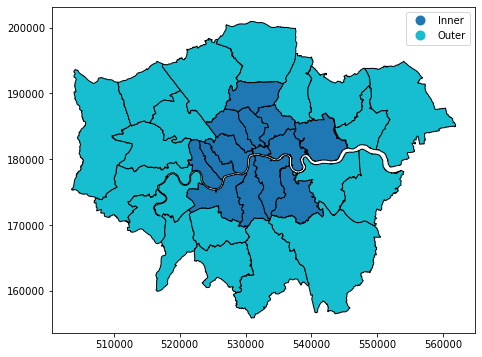

In [5]:
shape=gpd.read_file('/Users/sreevathsadb/Masters/Sem 2/Data Analytics Project/Data/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')
lb['InOut']= ['Inner'if i=='T'else'Outer'for i in lb['ONS_INNER']]
lb.plot(column='InOut',legend=True,categorical=True,edgecolor='black')

The above map divide london bouroughs into two : Innner and Outer London

## House Density Plot(Refer Turtorial EDA)

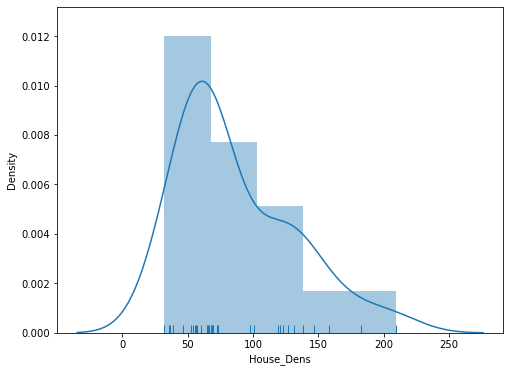

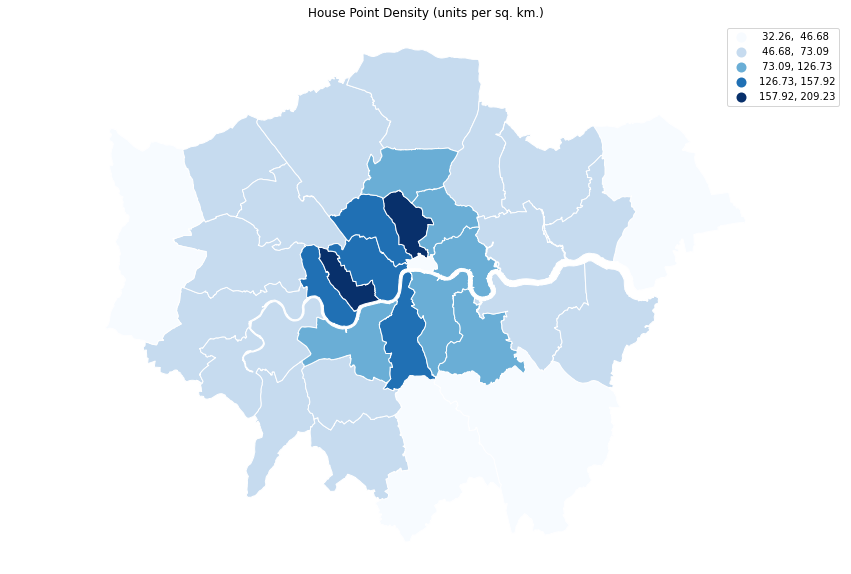

In [6]:
houses_unique_lb_den = houses_unique_lb.groupby(['NAME','HECTARES'])['postcode'].count().reset_index(name ='House_Count')
lb2 = lb_map.merge(houses_unique_lb_den)
lb2['House_Dens'] = lb2['House_Count']/(lb2['HECTARES']*.01)
h = sns.distplot(lb2['House_Dens'], bins=5, rug=True)
ei5 = mapclassify.FisherJenks(lb2.House_Dens, k=5)
#ei5
f, ax = plt.subplots(1, figsize=(15, 10)) #Subplots allows you to draw multiple plots in one figure
lb2.plot(ax=ax, column='House_Dens', legend=True, cmap='Blues', scheme='FisherJenks', k=5, edgecolor='white')
ax.set_axis_off() #Remove axes from plot 
ax.set_title('House Point Density (units per sq. km.)') #Plot title text
plt.axis('equal') #Set x and y axes to be equal size
plt.show()

In [7]:
top_hdens = lb2[["NAME","House_Dens"]]

top_hdens = top_hdens.sort_values(by=['House_Dens'],ascending=False)
top_hdens.head(2)

,NAME,House_Dens
23,Kensington and Chelsea,209.225124
27,Islington,182.275400


<AxesSubplot:>

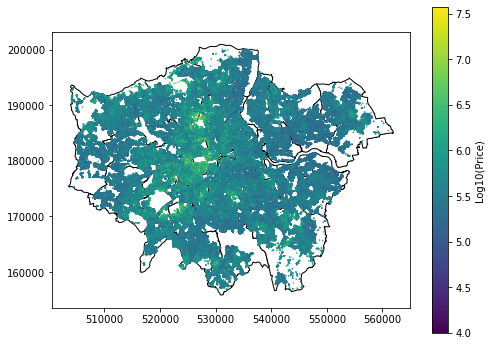

In [8]:
point = hp_all
point['logprice']=np.log10(point['price'])
base=lb.plot(facecolor='white',edgecolor='black')
point.plot(ax=base,column='logprice',markersize=.25,legend=True,legend_kwds={'label':'Log10(Price)'})

<AxesSubplot:>

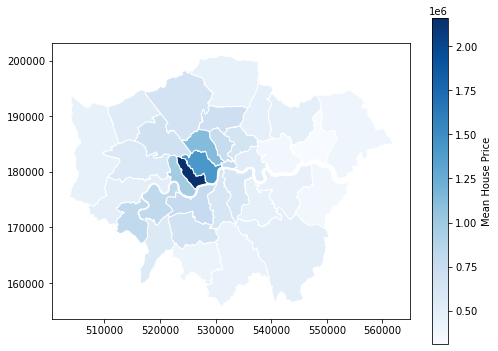

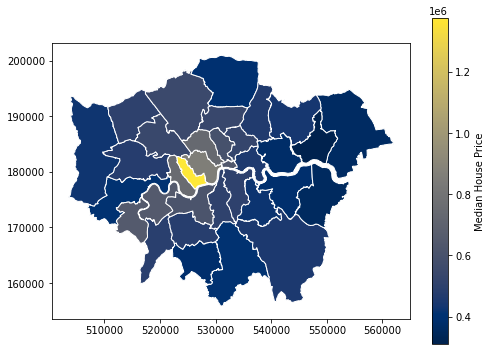

In [9]:
hp3 = hp
hp4=hp3.groupby('NAME').agg({'price':['mean','median']})
hp4.columns=['Mean_Price','Median_Price']
hp4=hp4.reset_index()
lb4=lb.merge(hp4)
lb4.plot(column='Mean_Price',cmap='Blues', 
         legend=True,legend_kwds={'label':'Mean House Price'},edgecolor='white')
lb4.plot(column='Median_Price',cmap='cividis', legend=True,legend_kwds={'label':'Median House Price'},edgecolor='white')

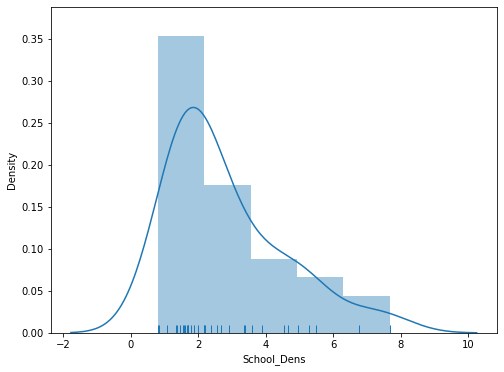

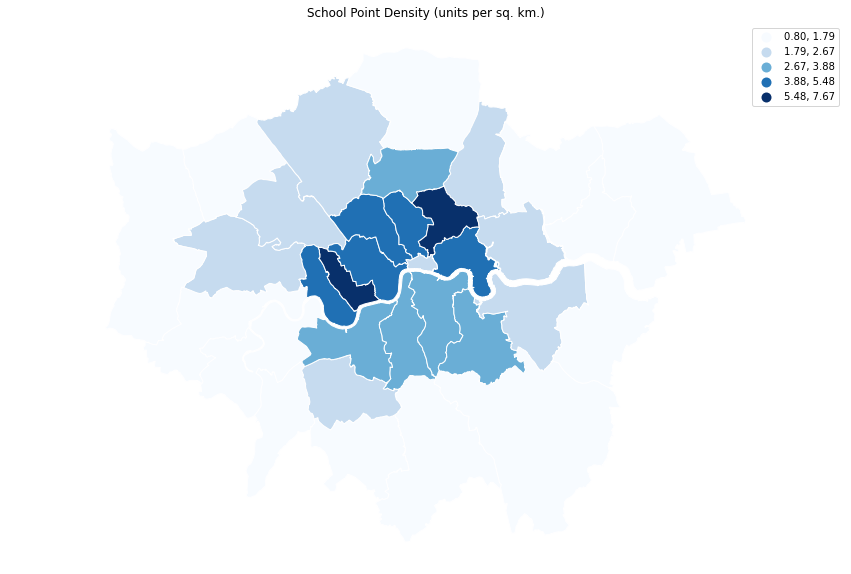

In [10]:
schools_london_shp = gpd.read_file('/Users/sreevathsadb/Masters/Sem 2/Data Analytics Project/Data/All_schools_shp/school_data_london_Atlas_2016.shp')
schools_london_shp = schools_london_shp.to_crs({'init': 'epsg:27700'})
schools_london = schools_london_shp
schools_london = schools_london[schools_london['STATUS'] == 'Open']
schools_cleaned = schools_london[schools_london['LA_NAME'].isin(lb['NAME'].unique())]
schools_col = ['OBJECTID','TOWN','STATUS','GENDER','LA_NAME','POSTCODE','geometry']
sc = schools_cleaned[schools_col]
school_den = sc.groupby(['LA_NAME'])['OBJECTID'].count().reset_index(name ='School_Count')
school_den.rename(columns={"LA_NAME":"NAME"},inplace=True)
lb3 = lb_map.merge(school_den)
lb3['School_Dens'] = lb3['School_Count']/(lb3['HECTARES']*.01)
s = sns.distplot(lb3['School_Dens'], bins=5, rug=True)
ei5 = mapclassify.FisherJenks(lb3.School_Dens, k=5)
f, ax = plt.subplots(1, figsize=(15, 10)) #Subplots allows you to draw multiple plots in one figure
lb3.plot(ax=ax, column='School_Dens', legend=True, cmap='Blues', scheme='FisherJenks', k=5, edgecolor='white')
ax.set_axis_off() #Remove axes from plot 
ax.set_title('School Point Density (units per sq. km.)') #Plot title text
plt.axis('equal') #Set x and y axes to be equal size
plt.show()

In [11]:
top_sdens = lb3[["NAME","School_Dens"]]
top_sdens = top_sdens.sort_values(by=['School_Dens'],ascending=False)
top_sdens.head(2)

,NAME,School_Dens
23,Kensington and Chelsea,7.671319
28,Hackney,6.772002


## Schools Density Plot Pending

In [12]:
hp['Detached'] = np.where(hp['propertytype']=='D', 1, 0)
hp['Flats'] = np.where(hp['propertytype']=='F', 1, 0)
hp['New'] = np.where(hp['oldnew']=='Y', 1, 0)
hp['Duration'] = np.where(hp['duration']=='L', 1, 0)

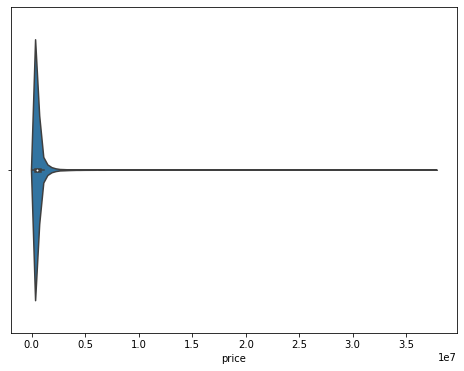

In [13]:
bx = sns.violinplot(x=hp["price"])

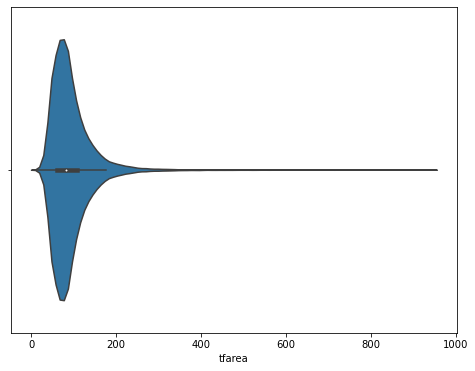

In [14]:
bx = sns.violinplot(x=(hp["tfarea"]))

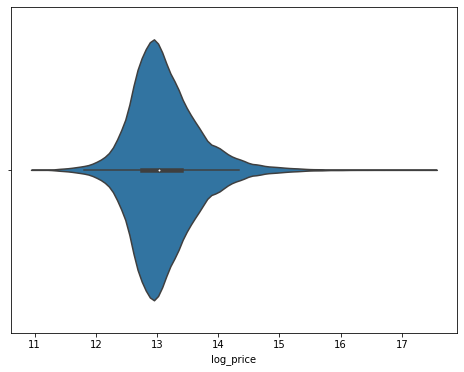

In [15]:
hp['log_area'] = np.log(hp['tfarea'])
hp['log_price'] = np.log(hp['price'])
bx = sns.violinplot(x=hp["log_price"])


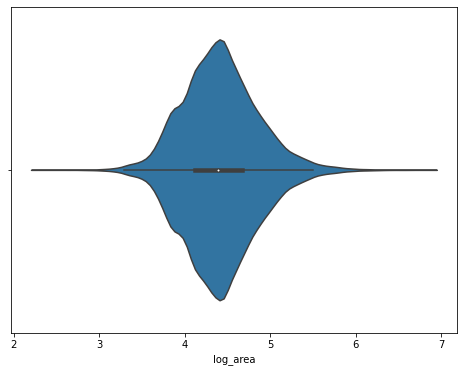

In [16]:
by = sns.violinplot(x=hp["log_area"])

In [17]:
oa = gpd.read_file('/Users/sreevathsadb/Masters/Sem 2/Data Analytics Project/Data/OutputAreas.geojson')
hp2 = gpd.sjoin(hp,oa)
pd.set_option('display.max_columns', None)
hp2.head()

,postcode,price,dateoftransfer,propertytype,oldnew,duration,categorytype,recordstatus,year,tfarea,numberrooms,priceper,pcd,pcd2,dointr,doterm,Dist_Road,Dist_Transit,Dist_Open,Dist_School,Dist_KM0,NAME,GSS_CODE,HECTARES_left,geometry,Detached,Flats,New,Duration,log_area,log_price,index_right,geo_code,label,NAME_2,POP,POPDENS,HH,HECTARES_right,DEPRHH,EMPRES,STUDENT,PROFSCI,Trees,TreeDens
0,SW118NJ,445000.0,2018-10-01,F,N,L,A,A,2018.0,47.0,2.0,9468.085106,SW118NJ,SW11 8NJ,201611.0,NaN,413.309821,493.259989,91.346613,581.812152,3157.381520,Wandsworth,E09000032,3522.022,POINT (528688.000 177523.000),0,1,0,1,3.850148,13.005830,4378,E00171041,E92000001E09000032E00171041,Wandsworth,343.0,451.31580,226.0,0.76,0.774336,248,0.126582,0.160156,0.0,0.0
1,SW118NP,580000.0,2018-10-17,F,N,L,A,A,2018.0,72.0,2.0,8055.555556,SW118NP,SW11 8NP,201611.0,NaN,222.796736,154.996066,45.430050,267.661970,3469.530922,Wandsworth,E09000032,3522.022,POINT (528691.000 177180.000),0,1,0,1,4.276666,13.270783,4627,E00171047,E92000001E09000032E00171047,Wandsworth,240.0,23.12139,156.0,10.38,0.724359,185,0.036364,0.219251,0.0,0.0
2,SW118NG,121250.0,2018-07-03,F,N,L,A,A,2018.0,45.0,2.0,2694.444444,SW118NG,SW11 8NG,201611.0,NaN,382.550649,386.960426,76.169505,481.284015,3254.477958,Wandsworth,E09000032,3522.022,POINT (528688.000 177416.000),0,1,0,1,3.806662,11.705610,4627,E00171047,E92000001E09000032E00171047,Wandsworth,240.0,23.12139,156.0,10.38,0.724359,185,0.036364,0.219251,0.0,0.0
3,SW185UL,1200000.0,2018-06-21,T,N,F,A,A,2018.0,122.0,6.0,9836.065574,SW185UL,SW18 5UL,198001.0,NaN,640.013514,347.835843,371.953301,239.273688,8503.184623,Wandsworth,E09000032,3522.022,POINT (524724.000 173738.000),0,0,0,0,4.804021,13.997832,4197,E00023163,E92000001E09000032E00023163,Wandsworth,304.0,109.74730,109.0,2.77,0.293578,153,0.050926,0.221519,0.0,0.0
263,SW185UH,1190000.0,2018-08-31,T,N,F,A,A,2018.0,117.1,6.0,10162.254483,SW185UH,SW18 5UH,198001.0,NaN,693.353300,316.687973,383.716005,240.288460,8502.438029,Wandsworth,E09000032,3522.022,POINT (524768.000 173704.000),0,0,0,0,4.763028,13.989464,4197,E00023163,E92000001E09000032E00023163,Wandsworth,304.0,109.74730,109.0,2.77,0.293578,153,0.050926,0.221519,0.0,0.0


In [18]:
variable_names = ['log_area', 'numberrooms', 'Flats', 'Detached','New','DEPRHH','Duration']

In [19]:
w = weights.DistanceBand.from_dataframe(hp2, 500) # Weights based on features within 500 meters

In [20]:
hp2["Dist_Road"] = pd.to_numeric(hp2["Dist_Road"])
hp2["Dist_KM0"] = pd.to_numeric(hp2["Dist_KM0"])
hp2["Dist_Transit"] = pd.to_numeric(hp2["Dist_Transit"])
hp2["Dist_Open"] = pd.to_numeric(hp2["Dist_Open"])
hp2["Dist_School"] = pd.to_numeric(hp2["Dist_School"])
dist_names = ['Dist_KM0'] + ["Dist_Road"] + ['Dist_Transit'] + ['Dist_Open'] + ['Dist_School']
all_names = variable_names + dist_names
all_names

['log_area',
 'numberrooms',
 'Flats',
 'Detached',
 'New',
 'DEPRHH',
 'Duration',
 'Dist_KM0',
 'Dist_Road',
 'Dist_Transit',
 'Dist_Open',
 'Dist_School']

In [21]:
m4 = spreg.OLS(hp2[['log_price']].values, hp2[all_names].values,
                name_y='log_price', name_x=all_names, robust='white', w=w, spat_diag=True, moran=True)
print(m4.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:       59592
Mean dependent var  :     13.1134                Number of Variables   :          13
S.D. dependent var  :      0.5644                Degrees of Freedom    :       59579
R-squared           :      0.7699
Adjusted R-squared  :      0.7698
Sum squared residual:    4368.698                F-statistic           :  16608.3222
Sigma-square        :       0.073                Prob(F-statistic)     :           0
S.E. of regression  :       0.271                Log likelihood        :   -6698.757
Sigma-square ML     :       0.073                Akaike info criterion :   13423.513
S.E of regression ML:      0.2708                Schwarz criterion     :   13540.452

White Standard Errors
-------------------------------------------------------

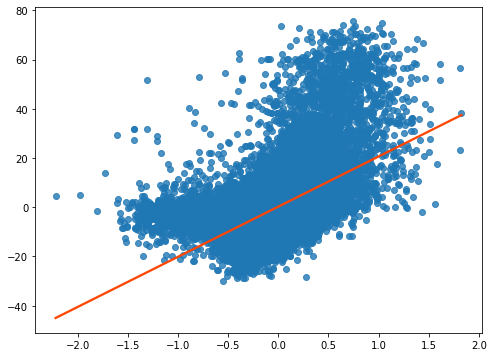

In [22]:
lag_residual = weights.spatial_lag.lag_spatial(w, m4.u)
sns.regplot(m4.u.flatten(), lag_residual.flatten(), 
                line_kws=dict(color='orangered'),
                ci=None);

('WARNING: ', 6146, ' is an island (no neighbors)')
('WARNING: ', 6490, ' is an island (no neighbors)')
('WARNING: ', 8375, ' is an island (no neighbors)')
('WARNING: ', 6690, ' is an island (no neighbors)')
('WARNING: ', 7294, ' is an island (no neighbors)')
('WARNING: ', 7442, ' is an island (no neighbors)')
('WARNING: ', 12901, ' is an island (no neighbors)')
('WARNING: ', 16413, ' is an island (no neighbors)')
('WARNING: ', 15975, ' is an island (no neighbors)')
('WARNING: ', 16459, ' is an island (no neighbors)')
('WARNING: ', 16765, ' is an island (no neighbors)')
('WARNING: ', 16871, ' is an island (no neighbors)')
('WARNING: ', 19907, ' is an island (no neighbors)')
('WARNING: ', 17470, ' is an island (no neighbors)')
('WARNING: ', 19729, ' is an island (no neighbors)')
('WARNING: ', 18064, ' is an island (no neighbors)')
('WARNING: ', 19534, ' is an island (no neighbors)')
('WARNING: ', 18527, ' is an island (no neighbors)')
('WARNING: ', 20230, ' is an island (no neighbors)')

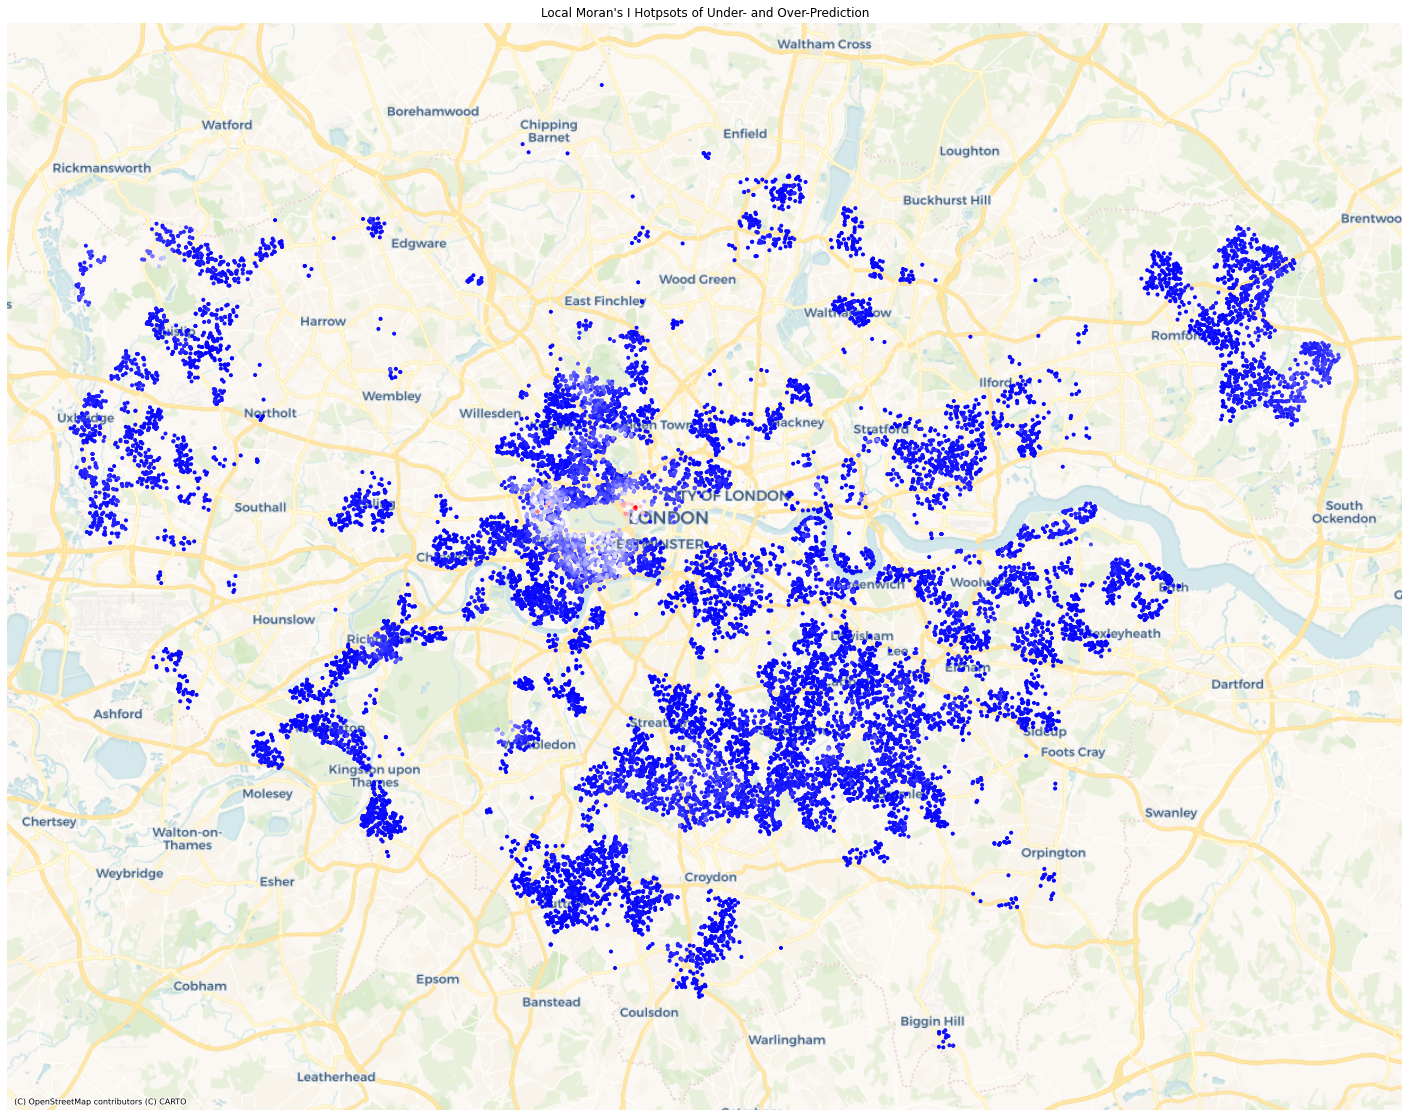

In [23]:
outliers = esda.moran.Moran_Local(m4.u, w, permutations=999)
error_clusters = (outliers.q % 2 == 1) # only the cluster cores
error_clusters &= (outliers.p_sim <= .001) # filtering out non-significant clusters
f, ax = plt.subplots(1, figsize=(25, 20)) #Subplots allows you to draw multiple plots in one figure
hp2.assign(error_clusters = error_clusters,
          local_I = outliers.Is)\
  .query("error_clusters")\
  .sort_values('local_I')\
  .to_crs('EPSG:3857').plot('local_I', cmap='bwr', marker='.', ax=ax)
ax.set_title("Local Moran's I Hotpsots of Under- and Over-Prediction")
ax.set_axis_off() #Remove axes from plot 
plt.axis('equal') #Set x and y axes to be equal size
cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager)

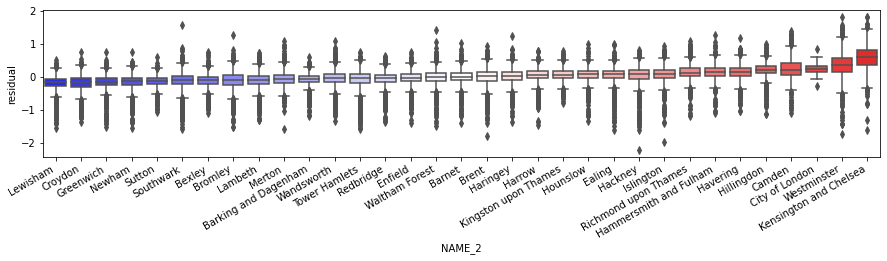

In [24]:
hp2['residual'] = m4.u
medians = hp2.groupby("NAME_2").residual.median().to_frame('hood_residual')

f = plt.figure(figsize=(15,3))
ax = plt.gca()
sns.boxplot('NAME_2', 'residual', ax = ax,
                data=hp2.merge(medians, how='left',
                              left_on='NAME_2',
                              right_index=True)
                   .sort_values('hood_residual'), palette='bwr')
f.autofmt_xdate()
plt.show()

In [25]:
m6 = spreg.GM_Lag(hp2[['log_price']].values, hp2[all_names].values,
                     w=w, name_y='log_price', name_x=all_names, robust='white')
print(m6.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:       59592
Mean dependent var  :     13.1134                Number of Variables   :          14
S.D. dependent var  :      0.5644                Degrees of Freedom    :       59578
Pseudo R-squared    :      0.7836
Spatial Pseudo R-squared:  0.7699

White Standard Errors
------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       9.8791481       0.1625465      60.7773798       0.0000000
            log_area       0.7102968       0.0068811     103.2243644       0.0000000
         numberrooms       0.0184045 

In [26]:
m7 = spreg.GM_Error_Het(hp2[['log_price']].values, hp2[all_names].values,
                     w=w, name_y='log_price', name_x=all_names)
print(m7.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES (HET)
---------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:       59592
Mean dependent var  :     13.1134                Number of Variables   :          13
S.D. dependent var  :      0.5644                Degrees of Freedom    :       59579
Pseudo R-squared    :      0.7555
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      11.2413839       0.0283456     396.5828554       0.0000000
            log_area       0.6172956       0.0053628     115.1075160       0.00

In [27]:
m8 = spreg.GM_Combo_Het(hp2[['log_price']].values, hp2[all_names].values,
                     w=w, name_y='log_price', name_x=all_names)
print(m8.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED TWO STAGE LEAST SQUARES (HET)
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:       59592
Mean dependent var  :     13.1134                Number of Variables   :          14
S.D. dependent var  :      0.5644                Degrees of Freedom    :       59578
Pseudo R-squared    :      0.7566
Spatial Pseudo R-squared:  0.7563
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      11.2101865       0.0802566     139.6792341       0.0000000
            log_area     

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score,  roc_curve, auc, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler ,LabelEncoder
from sklearn.neighbors import KNeighborsRegressor as NN
from sklearn.model_selection import GridSearchCV

In [29]:
hp_KNN = hp
number=LabelEncoder();
hp_KNN['propertytype']=number.fit_transform(hp_KNN['propertytype'].astype('str'))
hp_KNN['oldnew']=number.fit_transform(hp_KNN['oldnew'].astype('str'))
hp_KNN['duration']=number.fit_transform(hp_KNN['duration'].astype('str'))
hp_KNN['categorytype']=number.fit_transform(hp_KNN['categorytype'].astype('str'))
hp_KNN['NAME'] = number.fit_transform(hp_KNN['NAME'].astype('str'))
hp_KNN['longitude']=hp.geometry.x
hp_KNN['latitude']=hp.geometry.y

In [30]:
hp_KNN_cleaned = hp_KNN.drop(["postcode", "dateoftransfer", "recordstatus", "priceper","pcd","pcd2","dointr","doterm","GSS_CODE","geometry","Detached","Flats","New"], axis=1)

In [31]:
hp_KNN_cleaned.head()

,price,propertytype,oldnew,duration,categorytype,year,tfarea,numberrooms,Dist_Road,Dist_Transit,Dist_Open,Dist_School,Dist_KM0,NAME,HECTARES,Duration,log_area,log_price,longitude,latitude
0,445000.0,1,0,1,0,2018.0,47.0,2.0,413.309821,493.259989,91.346613,581.812152,3157.381520,31,3522.022,1,3.850148,13.005830,528688.0,177523.0
1,580000.0,1,0,1,0,2018.0,72.0,2.0,222.796736,154.996066,45.430050,267.661970,3469.530922,31,3522.022,1,4.276666,13.270783,528691.0,177180.0
2,121250.0,1,0,1,0,2018.0,45.0,2.0,382.550649,386.960426,76.169505,481.284015,3254.477958,31,3522.022,1,3.806662,11.705610,528688.0,177416.0
3,1200000.0,3,0,0,0,2018.0,122.0,6.0,640.013514,347.835843,371.953301,239.273688,8503.184623,31,3522.022,0,4.804021,13.997832,524724.0,173738.0
4,265000.0,1,0,1,0,2018.0,39.0,2.0,196.219867,627.226931,422.338479,205.949983,9923.855498,31,3522.022,1,3.663562,12.487485,527290.0,170842.0


In [32]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('zscores',StandardScaler()),('NNreg',NN())])

from sklearn.metrics import mean_absolute_error, make_scorer
mae = make_scorer(mean_absolute_error,greater_is_better=False)

In [33]:
hp_KNN_cleaned.head()

,price,propertytype,oldnew,duration,categorytype,year,tfarea,numberrooms,Dist_Road,Dist_Transit,Dist_Open,Dist_School,Dist_KM0,NAME,HECTARES,Duration,log_area,log_price,longitude,latitude
0,445000.0,1,0,1,0,2018.0,47.0,2.0,413.309821,493.259989,91.346613,581.812152,3157.381520,31,3522.022,1,3.850148,13.005830,528688.0,177523.0
1,580000.0,1,0,1,0,2018.0,72.0,2.0,222.796736,154.996066,45.430050,267.661970,3469.530922,31,3522.022,1,4.276666,13.270783,528691.0,177180.0
2,121250.0,1,0,1,0,2018.0,45.0,2.0,382.550649,386.960426,76.169505,481.284015,3254.477958,31,3522.022,1,3.806662,11.705610,528688.0,177416.0
3,1200000.0,3,0,0,0,2018.0,122.0,6.0,640.013514,347.835843,371.953301,239.273688,8503.184623,31,3522.022,0,4.804021,13.997832,524724.0,173738.0
4,265000.0,1,0,1,0,2018.0,39.0,2.0,196.219867,627.226931,422.338479,205.949983,9923.855498,31,3522.022,1,3.663562,12.487485,527290.0,170842.0


In [34]:
predictor_scaler = StandardScaler()
predictor_scaler.fit(hp_KNN_cleaned[['propertytype','oldnew','duration','categorytype','year','tfarea','numberrooms','longitude','latitude','Dist_School']])

X = predictor_scaler.transform(hp_KNN_cleaned[['propertytype','oldnew','duration','categorytype','year','tfarea','numberrooms','longitude','latitude','Dist_School']])
y= hp_KNN_cleaned[['price']]/1000.0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

#Test 1

KN = NN(n_neighbors=8,weights='uniform',p=1)
KN.fit(X_train,y_train)

KN.score(X_test, y_test)

from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(KN, X, y, cv=4)

print('cv_scores mean:{}'.format(np.mean(cv_scores)))

#Test 2

KN2 = NN(n_neighbors=14,weights='distance',p=1)
KN2.fit(X_train,y_train)
KN2.score(X_test, y_test)

cv_scores = cross_val_score(KN2, X, y, cv=4)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

#Test 3

KN3 = NN(n_neighbors=20,weights='distance',p=2)
KN3.fit(X_train,y_train)
KN3.score(X_test, y_test)

cv_scores = cross_val_score(KN3, X, y, cv=5)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

#Test 4

KN4 = NN(n_neighbors=50,weights='uniform',p=2)
KN4.fit(X_train,y_train)
KN4.score(X_test, y_test)

cv_scores = cross_val_score(KN4, X, y, cv=3)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

#Test 5

KN5 = NN(n_neighbors=9,weights='distance',p=1)
KN5.fit(X_train,y_train)
KN5.score(X_test, y_test)

cv_scores = cross_val_score(KN5, X, y, cv=4)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

#Test 6

KN6 = NN(n_neighbors=20,weights='distance',p=1)
KN6.fit(X_train,y_train)
KN6.score(X_test, y_test)

cv_scores = cross_val_score(KN6, X, y, cv=3)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

#Test 7

KN7 = NN(n_neighbors=9,weights='uniform',p=1)
KN7.fit(X_train,y_train)
KN7.score(X_test, y_test)

cv_scores = cross_val_score(KN7, X, y, cv=4)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

#Test 8

KN8 = NN(n_neighbors=90,weights='uniform',p=2)
KN8.fit(X_train,y_train)
KN8.score(X_test, y_test)
cv_scores = cross_val_score(KN8, X, y, cv=4)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

KN8.score(X_test, y_test)

#Test 9

KN9 = NN(n_neighbors=75,weights='distance',p=2)
KN9.fit(X_train,y_train)
KN9.score(X_test, y_test)
cv_scores = cross_val_score(KN9, X, y, cv=4)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

KN9.score(X_test, y_test)

#Test 10

KN10 = NN(n_neighbors=150,weights='distance',p=2)
KN10.fit(X_train,y_train)
KN10.score(X_test, y_test)
cv_scores = cross_val_score(KN10, X, y, cv=3)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

KN10.score(X_test, y_test)

#Optimum parameters

optimal_nn = GridSearchCV(
    estimator = NN(),
    param_grid = {
        'n_neighbors':range(1,20),
        'weights':['uniform','distance'],
        'p':[1,2]},
    verbose=2,
cv=4)
optimal_nn.fit(X,y)

optimal_nn.best_params_

optimal_nn.best_score_

optimal_KNN = NN(n_neighbors=18,weights='distance',p=1)
optimal_cv_scores = cross_val_score(optimal_KNN, X, y, cv=4)
#each cross-validation score ie. accuracy and average their average
print('cv_scores mean:{}'.format(np.mean(optimal_cv_scores)))

cv_scores mean:0.6510663941679788
cv_scores mean:0.6648865672155007
cv_scores mean:0.6153070178328861
cv_scores mean:0.6368001024889501
cv_scores mean:0.6538511109375809
cv_scores mean:0.6408992399496194
cv_scores mean:0.6557620235710562
cv_scores mean:0.6288477617460158
cv_scores mean:0.6445203564752131
cv_scores mean:0.6339665163929035
Fitting 4 folds for each of 76 candidates, totalling 304 fits
[CV] END ................n_neighbors=1, p=1, weights=uniform; total time=   0.6s
[CV] END ................n_neighbors=1, p=1, weights=uniform; total time=   0.8s
[CV] END ................n_neighbors=1, p=1, weights=uniform; total time=   0.5s
[CV] END ................n_neighbors=1, p=1, weights=uniform; total time=   0.7s
[CV] END ...............n_neighbors=1, p=1, weights=distance; total time=   0.6s
[CV] END ...............n_neighbors=1, p=1, weights=distance; total time=   0.8s
[CV] END ...............n_neighbors=1, p=1, weights=distance; total time=   0.5s
[CV] END ...............n_neigh

[CV] END ................n_neighbors=7, p=1, weights=uniform; total time=   1.3s
[CV] END ................n_neighbors=7, p=1, weights=uniform; total time=   0.9s
[CV] END ................n_neighbors=7, p=1, weights=uniform; total time=   1.1s
[CV] END ...............n_neighbors=7, p=1, weights=distance; total time=   1.4s
[CV] END ...............n_neighbors=7, p=1, weights=distance; total time=   1.3s
[CV] END ...............n_neighbors=7, p=1, weights=distance; total time=   0.9s
[CV] END ...............n_neighbors=7, p=1, weights=distance; total time=   1.1s
[CV] END ................n_neighbors=7, p=2, weights=uniform; total time=   0.7s
[CV] END ................n_neighbors=7, p=2, weights=uniform; total time=   0.9s
[CV] END ................n_neighbors=7, p=2, weights=uniform; total time=  14.0s
[CV] END ................n_neighbors=7, p=2, weights=uniform; total time=   0.8s
[CV] END ...............n_neighbors=7, p=2, weights=distance; total time=   0.7s
[CV] END ...............n_ne

[CV] END ..............n_neighbors=13, p=1, weights=distance; total time=   1.3s
[CV] END ...............n_neighbors=13, p=2, weights=uniform; total time=   0.9s
[CV] END ...............n_neighbors=13, p=2, weights=uniform; total time=   1.1s
[CV] END ...............n_neighbors=13, p=2, weights=uniform; total time=   0.8s
[CV] END ...............n_neighbors=13, p=2, weights=uniform; total time=   0.9s
[CV] END ..............n_neighbors=13, p=2, weights=distance; total time=   0.9s
[CV] END ..............n_neighbors=13, p=2, weights=distance; total time=   1.1s
[CV] END ..............n_neighbors=13, p=2, weights=distance; total time=   0.8s
[CV] END ..............n_neighbors=13, p=2, weights=distance; total time=   0.9s
[CV] END ...............n_neighbors=14, p=1, weights=uniform; total time=   1.3s
[CV] END ...............n_neighbors=14, p=1, weights=uniform; total time=   1.5s
[CV] END ...............n_neighbors=14, p=1, weights=uniform; total time=   1.1s
[CV] END ...............n_ne

[CV] END ..............n_neighbors=19, p=2, weights=distance; total time=   1.3s
[CV] END ..............n_neighbors=19, p=2, weights=distance; total time=   0.9s
[CV] END ..............n_neighbors=19, p=2, weights=distance; total time=   1.0s
cv_scores mean:0.6715526006108558
